In [2]:
import os
import re
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sparta.Statistics as stat

In [3]:
# Load data for all stars by looping through the directory
delCep_results = []
wv_ranges = []
wv_ranges_size = []
pattern = re.compile(r'delCep_Hermes_spectra_(\d+)_(\d+)\.csv')
for filename in os.listdir('./delCep'):
    delCep_results.append(stat.open_csv('./delCep/'+filename))
    match = pattern.match(filename)
    if match:
        wv1, wv2 = match.groups()
        wv_range = f"{wv1}-{wv2}"
        wv_ranges.append(wv_range)
        wv_ranges_size.append(int(wv2)-int(wv1))
print(wv_ranges)
print(wv_ranges_size)

['4001-4011', '4008-5504', '4009-4016', '4032-4096', '4036-4177', '4036-5532', '4040-5536', '4054-5283', '4076-5305', '4092-4652', '4096-5592', '4098-5594', '4107-4223', '4109-4669', '4110-4119', '4117-4130', '4119-4143', '4129-4158', '4130-5139', '4138-4143', '4138-4967', '4158-4193', '4174-5403', '4199-4223', '4225-4260', '4226-4786', '4235-5464', '4237-4918', '4243-4250', '4245-5474', '4250-5259', '4261-4270', '4290-4600', '4306-4478', '4310-4770', '4327-5336', '4338-4343', '4347-4442', '4350-4402', '4354-4470', '4355-4365', '4355-4610', '4370-5199', '4378-4391', '4383-4393', '4389-4432', '4400-5229', '4401-4417', '4401-4573', '4409-4422', '4410-4582', '4428-5257', '4441-4519', '4471-5480', '4473-4479', '4494-4589', '4496-4505', '4505-4677', '4506-5515', '4558-4699', '4579-5139', '4584-4594', '4587-4594', '4591-4846', '4619-4714', '4632-4651', '4644-4739', '4658-4664', '4667-4676', '4678-5138', '4679-4820', '4685-4720', '4685-4894', '4690-5000', '4700-4743', '4704-4959', '4706-5535'

In [4]:
print(len(delCep_results))

152


In [5]:
period_truth = 5.366267

In [ ]:
# Create a figure with 11 subfigures arranged in a 4*3 grid
plt.style.use('sparta')

fig = plt.figure(constrained_layout=False, figsize=(30, 20))
fig.suptitle(r'$\delta$ Cephei - Wavelength Range Analysis', fontsize='x-large')

# plt.suptitle(r'$\delta$ Cephei - Tellurics Analysis', fontsize='x-large')

subfigs = fig.subfigures(6, 4)

for outerind, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(3, 1,sharex=True)
    if outerind<=22:
        subfig.suptitle(wv_ranges[outerind]+' $\AA$')
        for innerind, ax in enumerate(axs.flat):
            if innerind==0:
                ax.plot(delCep_results[outerind]['period'], delCep_results[outerind]['gls'],linewidth=0.5)
                ax.axvline(period_truth, color='r', linestyle='--',linewidth=0.5)
                ax.set_ylabel('Power', fontsize='small')
            elif innerind==1:
                ax.plot(delCep_results[outerind]['period'], delCep_results[outerind]['shape'],linewidth=0.5)
                ax.axvline(period_truth, color='r', linestyle='--',linewidth=0.5)
                ax.set_ylabel(r'Power - $D_{\phi s}$', fontsize='small')
            elif innerind==2:
                ax.plot(delCep_results[outerind]['period'],delCep_results[outerind]['shift'],linewidth=0.5)
                ax.axvline(period_truth, color='r', linestyle='--',linewidth=0.5)
                ax.set_ylabel(r'Power - $D_{\phi \nu}$', fontsize='small')
                ax.set_xlabel('Period (days)', fontsize='small')
            # Add a small text box
            text_box = f"{['GLS', 'Shape', 'Shift'][innerind]}"
            ax.text(0.05, 0.80, text_box, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
            ax.set_ylim(0,1)
            ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    #and recenter the last two that are not used
    else:
        for innerind, ax in enumerate(axs.flat):
            ax.axis('off')
plt.subplots_adjust(top=0.92, hspace=0.02, wspace=0.2)
plt.savefig('delCep_wv_ranges.png', dpi=450)
plt.show()

In [396]:
# find proeminences of the signal at a period of 5.366267 days

shape_proeminences = []
shift_proeminences = []
gls_proeminences = []
# print('True period is 5.366267 days')
for (idx, result),(_,wv) in zip(enumerate(delCep_results),enumerate(wv_ranges)):
    # first find the peaks for each range
    peaks_shape = find_peaks(result['shape'], distance=10)
    peaks_shift = find_peaks(result['shift'], distance=10)
    peaks_gls = find_peaks(result['gls'], distance=10)
    # compute the prominences
    shape_proeminence = peak_prominences(result['shape'], peaks_shape[0])[0]
    shift_proeminence = peak_prominences(result['shift'], peaks_shift[0])[0]
    gls_proeminence = peak_prominences(result['gls'], peaks_gls[0])[0]
    # restrain to prominence of peak closest to the truth
    shape_proeminence = shape_proeminence[np.argmin(np.abs(result['period'][peaks_shape[0]]-period_truth))]
    shape_proeminences.append(shape_proeminence)
    shift_proeminence = shift_proeminence[np.argmin(np.abs(result['period'][peaks_shift[0]]-period_truth))]
    shift_proeminences.append(shift_proeminence)
    gls_proeminence = gls_proeminence[np.argmin(np.abs(result['period'][peaks_gls[0]]-period_truth))]
    gls_proeminences.append(gls_proeminence)

In [397]:
wv_ranges_size_indices = np.argsort(wv_ranges_size)
wv_ranges_size = np.array(wv_ranges_size)[wv_ranges_size_indices]
shape_proeminences = np.array(shape_proeminences)[wv_ranges_size_indices]
shift_proeminences = np.array(shift_proeminences)[wv_ranges_size_indices]
gls_proeminences = np.array(gls_proeminences)[wv_ranges_size_indices]

In [398]:
wv_ranges_size_unique,counts = np.unique(wv_ranges_size,return_counts=True)
print(wv_ranges_size_unique)
print(counts)

[   5    6    7    9   10   13   16   19   24   29   35   43   52   64
   78   95  116  141  172  209  255  310  378  460  560  681  829 1009
 1229 1496]
[6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [399]:
# for every size, get the mean and std of the proeminences
shape_mean = []
shift_mean = []
gls_mean = []
shape_std = []
shift_std = []
gls_std = []

for size in wv_ranges_size_unique:
    shape_mean.append(np.mean(shape_proeminences[wv_ranges_size==size]))
    shift_mean.append(np.mean(shift_proeminences[wv_ranges_size==size]))
    gls_mean.append(np.mean(gls_proeminences[wv_ranges_size==size]))
    shape_std.append(np.std(shape_proeminences[wv_ranges_size==size]))
    shift_std.append(np.std(shift_proeminences[wv_ranges_size==size]))
    gls_std.append(np.std(gls_proeminences[wv_ranges_size==size]))



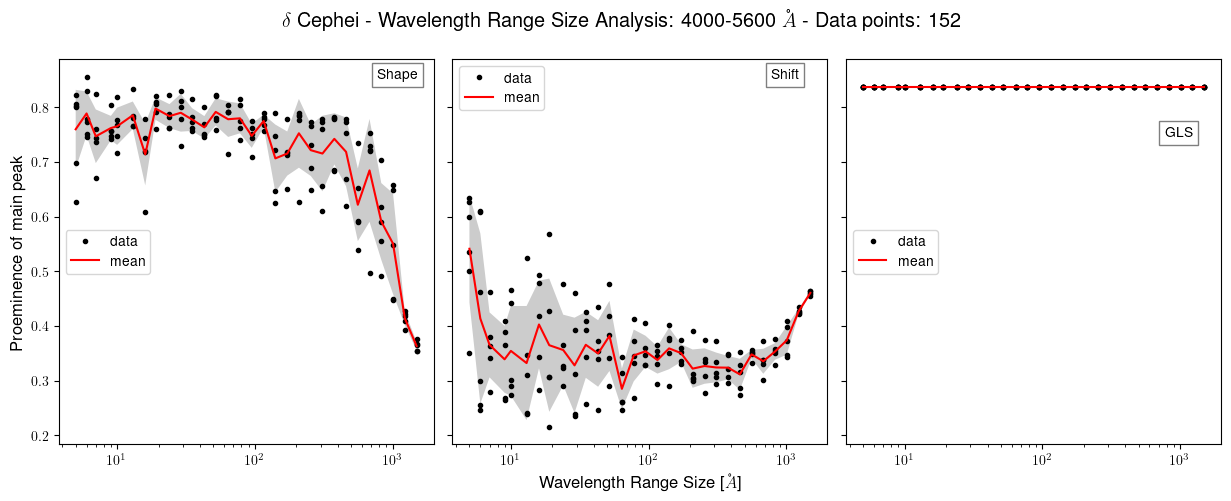

In [400]:
# plot the proeminences, put small box with shape, shift or gls
fig, ax = plt.subplots(1,3, figsize=(15,5),sharex=True,sharey=True)
plt.suptitle(r'$\delta$ Cephei - Wavelength Range Size Analysis: 4000-5600 $\AA$ - Data points: '+str(len(delCep_results)), fontsize='x-large')
ax[0].plot(wv_ranges_size, shape_proeminences, '.',label='data')
#use fill_between to plot the std
ax[0].fill_between(wv_ranges_size_unique, np.array(shape_mean)-np.array(shape_std), np.array(shape_mean)+np.array(shape_std), alpha=0.2)
ax[0].plot(wv_ranges_size_unique, shape_mean, 'r-',label='mean')
ax[0].text(0.85, 0.95, 'Shape', transform=ax[0].transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax[0].set_ylabel('Proeminence of main peak', fontsize='large')
ax[1].plot(wv_ranges_size, shift_proeminences, '.',label='data')
ax[1].plot(wv_ranges_size_unique, shift_mean, 'r-',label='mean')
ax[1].fill_between(wv_ranges_size_unique, np.array(shift_mean)-np.array(shift_std), np.array(shift_mean)+np.array(shift_std), alpha=0.2)
ax[1].text(0.85, 0.95, 'Shift', transform=ax[1].transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax[1].set_xlabel('Wavelength Range Size [$\AA$]', fontsize='large')
ax[2].plot(wv_ranges_size, gls_proeminences, '.',label='data')
ax[2].plot(wv_ranges_size_unique, gls_mean, 'r-',label='mean')
ax[2].fill_between(wv_ranges_size_unique, np.array(gls_mean)-np.array(gls_std), np.array(gls_mean)+np.array(gls_std), alpha=0.2)
ax[2].text(0.85, 0.8, 'GLS', transform=ax[2].transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.subplots_adjust(wspace=0.05)
ax[0].legend(loc = 'center left')
ax[1].legend(loc='upper left')
ax[2].legend(loc = 'center left')
#put in log scale on x axis
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
plt.savefig('delCep_wv_ranges_proeminences.png', dpi=450)
plt.show()

need to do for a little bit smaller range : 5,7,8

and slightly bigger : 1250,1500

read anderson thesis about cepheids because you don't have enough ground knowledge.

do e2ds file

do range size analysis for bgcru, rcru, rrlyr.

start with bgcru dissapearing peak.

## RR Lyrae

In [401]:
# Load data for all stars by looping through the directory
RRLyr_results = []
wv_ranges = []
wv_ranges_size = []
pattern = re.compile(r'RRLyr_Hermes_spectra_(\d+)_(\d+)\.csv')
for filename in os.listdir('./RRLyr'):
    RRLyr_results.append(stat.open_csv('./RRLyr/'+filename))
    match = pattern.match(filename)
    if match:
        wv1, wv2 = match.groups()
        wv_range = f"{wv1}-{wv2}"
        wv_ranges.append(wv_range)
        wv_ranges_size.append(int(wv2)-int(wv1))
print(wv_ranges)
print(wv_ranges_size)

['4000-5229', '4004-4213', '4008-4568', '4009-4387', '4010-4126', '4010-5506', '4011-4040', '4012-4472', '4014-4695', '4016-4326', '4018-4699', '4025-4089', '4025-5521', '4026-5255', '4027-4587', '4028-4092', '4030-4054', '4032-4148', '4043-5272', '4044-4087', '4051-5547', '4053-5062', '4062-4743', '4063-4073', '4065-4075', '4068-4240', '4068-5564', '4069-4210', '4071-4100', '4072-4327', '4076-4140', '4077-4101', '4077-5573', '4083-4112', '4083-5579', '4084-5313', '4087-5316', '4091-4300', '4095-4924', '4096-4160', '4099-4308', '4099-5595', '4101-5597', '4102-5111', '4103-4127', '4103-5332', '4105-4665', '4107-4185', '4115-4121', '4117-4123', '4119-4171', '4121-4130', '4128-4438', '4131-4303', '4132-4210', '4139-4968', '4140-4235', '4144-4173', '4153-4269', '4156-4365', '4157-4838', '4158-5167', '4159-4175', '4162-4257', '4165-4306', '4171-4343', '4172-4178', '4179-4257', '4183-4188', '4183-5192', '4185-4198', '4187-4265', '4191-4569', '4195-4311', '4203-4246', '4219-4243', '4226-5455'

In [402]:
period_truth = 0.566777

In [403]:
# find proeminences of the signal at a period of 5.366267 days

shape_proeminences = []
shift_proeminences = []
gls_proeminences = []
# print('True period is 5.366267 days')
for (idx, result),(_,wv) in zip(enumerate(RRLyr_results),enumerate(wv_ranges)):
    # first find the peaks for each range
    peaks_shape = find_peaks(result['shape'], distance=10)
    peaks_shift = find_peaks(result['shift'], distance=10)
    peaks_gls = find_peaks(result['gls'], distance=10)
    # compute the prominences
    shape_proeminence = peak_prominences(result['shape'], peaks_shape[0])[0]
    shift_proeminence = peak_prominences(result['shift'], peaks_shift[0])[0]
    gls_proeminence = peak_prominences(result['gls'], peaks_gls[0])[0]
    # restrain to prominence of peak closest to the truth
    shape_proeminence = shape_proeminence[np.argmin(np.abs(result['period'][peaks_shape[0]]-period_truth))]
    shape_proeminences.append(shape_proeminence)
    shift_proeminence = shift_proeminence[np.argmin(np.abs(result['period'][peaks_shift[0]]-period_truth))]
    shift_proeminences.append(shift_proeminence)
    gls_proeminence = gls_proeminence[np.argmin(np.abs(result['period'][peaks_gls[0]]-period_truth))]
    gls_proeminences.append(gls_proeminence)

In [404]:
wv_ranges_size_indices = np.argsort(wv_ranges_size)
wv_ranges_size = np.array(wv_ranges_size)[wv_ranges_size_indices]
shape_proeminences = np.array(shape_proeminences)[wv_ranges_size_indices]
shift_proeminences = np.array(shift_proeminences)[wv_ranges_size_indices]
gls_proeminences = np.array(gls_proeminences)[wv_ranges_size_indices]

In [405]:
wv_ranges_size_unique,counts = np.unique(wv_ranges_size,return_counts=True)
print(wv_ranges_size_unique)
print(counts)

[   5    6    7    9   10   13   16   19   24   29   35   43   52   64
   78   95  116  141  172  209  255  310  378  460  560  681  829 1009
 1229 1496]
[11 11 11 11 11 11 11 11 11 11 10 11 10 11 11 11 11 11 11 11 11 11 11 11
 11 11 10 11 11  8]


In [406]:
# for every size, get the mean and std of the proeminences
shape_mean = []
shift_mean = []
gls_mean = []
shape_std = []
shift_std = []
gls_std = []

for size in wv_ranges_size_unique:
    shape_mean.append(np.mean(shape_proeminences[wv_ranges_size==size]))
    shift_mean.append(np.mean(shift_proeminences[wv_ranges_size==size]))
    gls_mean.append(np.mean(gls_proeminences[wv_ranges_size==size]))
    shape_std.append(np.std(shape_proeminences[wv_ranges_size==size]))
    shift_std.append(np.std(shift_proeminences[wv_ranges_size==size]))
    gls_std.append(np.std(gls_proeminences[wv_ranges_size==size]))

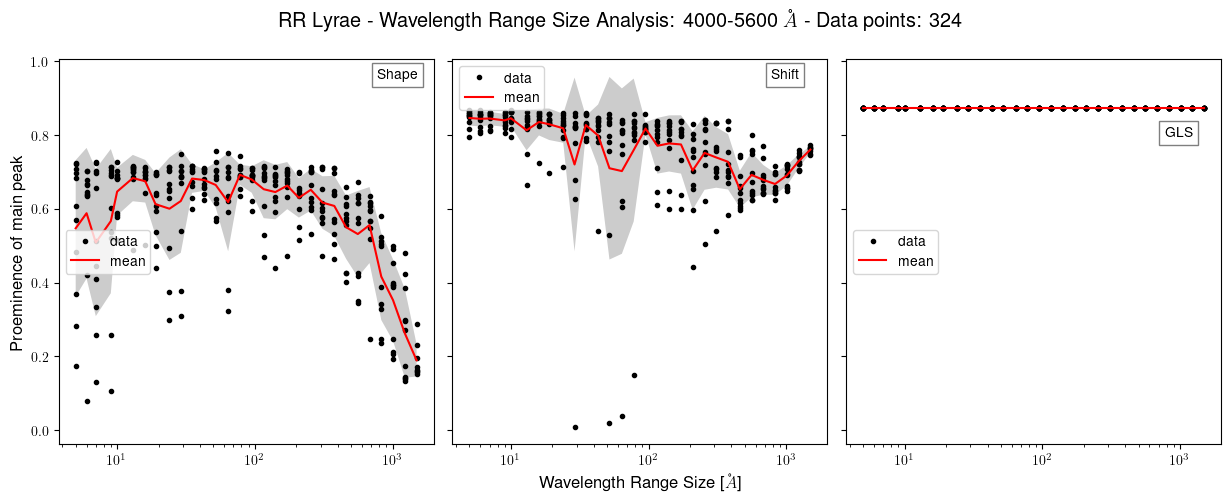

In [407]:
# plot the proeminences, put small box with shape, shift or gls
fig, ax = plt.subplots(1,3, figsize=(15,5),sharex=True,sharey=True)
plt.suptitle(r'RR Lyrae - Wavelength Range Size Analysis: 4000-5600 $\AA$ - Data points: '+str(len(RRLyr_results)), fontsize='x-large')
ax[0].plot(wv_ranges_size, shape_proeminences, '.',label='data')
#use fill_between to plot the std
ax[0].fill_between(wv_ranges_size_unique, np.array(shape_mean)-np.array(shape_std), np.array(shape_mean)+np.array(shape_std), alpha=0.2)
ax[0].plot(wv_ranges_size_unique, shape_mean, 'r-',label='mean')
ax[0].text(0.85, 0.95, 'Shape', transform=ax[0].transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax[0].set_ylabel('Proeminence of main peak', fontsize='large')
ax[1].plot(wv_ranges_size, shift_proeminences, '.',label='data')
ax[1].plot(wv_ranges_size_unique, shift_mean, 'r-',label='mean')
ax[1].fill_between(wv_ranges_size_unique, np.array(shift_mean)-np.array(shift_std), np.array(shift_mean)+np.array(shift_std), alpha=0.2)
ax[1].text(0.85, 0.95, 'Shift', transform=ax[1].transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax[1].set_xlabel('Wavelength Range Size [$\AA$]', fontsize='large')
ax[2].plot(wv_ranges_size, gls_proeminences, '.',label='data')
ax[2].plot(wv_ranges_size_unique, gls_mean, 'r-',label='mean')
ax[2].fill_between(wv_ranges_size_unique, np.array(gls_mean)-np.array(gls_std), np.array(gls_mean)+np.array(gls_std), alpha=0.2)
ax[2].text(0.85, 0.8, 'GLS', transform=ax[2].transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.subplots_adjust(wspace=0.05)
ax[0].legend(loc = 'center left')
ax[1].legend(loc='upper left')
ax[2].legend(loc = 'center left')
#put in log scale on x axis
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
plt.savefig('RRLyr_wv_ranges_proeminences.png', dpi=450)
plt.show()

In [340]:
obs = stat.open_csv('./RRLyr/RRLyr_Hermes_spectra_4802_4880.csv')

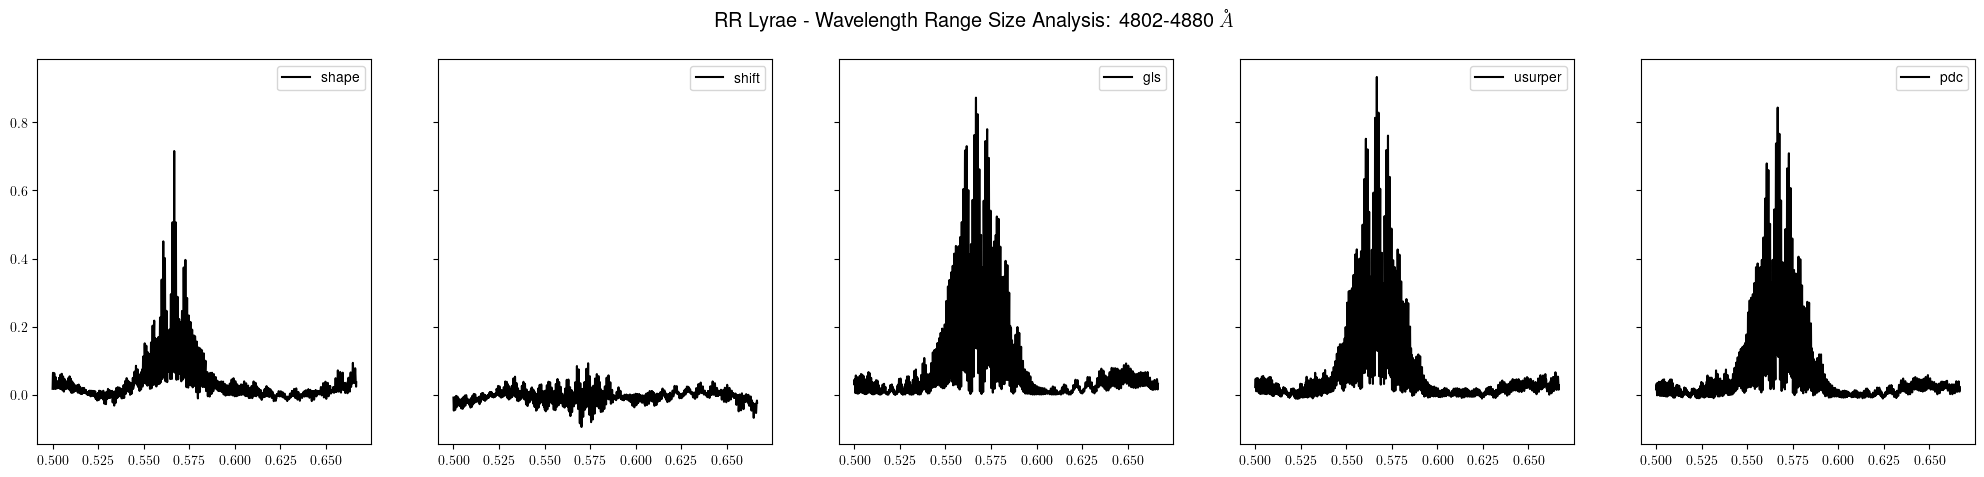

In [357]:
fig, ax = plt.subplots(1,5, figsize=(25,5),sharex=True,sharey=True)
plt.suptitle(r'RR Lyrae - Wavelength Range Size Analysis: 4802-4880 $\AA$', fontsize='x-large')
ax[0].plot(obs['period'], obs['shape'],label='shape')
ax[1].plot(obs['period'], obs['shift'],label='shift')
ax[2].plot(obs['period'], obs['gls'],label='gls')
ax[3].plot(obs['period'], obs['usurper'],label='usurper')
ax[4].plot(obs['period'], obs['pdc'],label='pdc')
for idx,_ in enumerate(ax):
    ax[idx].legend()

### R Crucis

In [408]:
# Load data for all stars by looping through the directory
RCru_results = []
wv_ranges = []
wv_ranges_size = []
pattern = re.compile(r'RCru_(\d+)_(\d+)\.csv')
for filename in os.listdir('./RCru'):
    RCru_results.append(stat.open_csv('./RCru/'+filename))
    match = pattern.match(filename)
    if match:
        wv1, wv2 = match.groups()
        wv_range = f"{wv1}-{wv2}"
        wv_ranges.append(wv_range)
        wv_ranges_size.append(int(wv2)-int(wv1))
print(wv_ranges)
print(wv_ranges_size)

['4004-4099', '4009-4125', '4010-4182', '4012-5021', '4013-4026', '4014-4024', '4014-4269', '4014-4843', '4017-5513', '4018-4328', '4019-4097', '4022-5518', '4026-5522', '4028-4283', '4028-5257', '4030-4059', '4031-5527', '4033-5529', '4036-5532', '4041-5537', '4044-5540', '4046-4606', '4048-5057', '4049-4127', '4053-5062', '4055-4090', '4056-5552', '4058-4082', '4060-5556', '4062-4271', '4064-4205', '4064-5293', '4066-4072', '4066-4626', '4070-5079', '4074-4126', '4075-4110', '4082-4160', '4082-5578', '4083-4107', '4084-5580', '4085-4257', '4088-4112', '4088-5584', '4089-4098', '4089-4167', '4089-5585', '4090-4206', '4094-4266', '4094-4654', '4096-4120', '4096-4556', '4096-5592', '4098-4133', '4101-4356', '4102-4311', '4109-5338', '4112-4121', '4119-4260', '4119-4374', '4121-4128', '4122-4146', '4127-4382', '4127-4587', '4128-4688', '4133-4593', '4134-4150', '4135-5364', '4140-5149', '4143-4153', '4143-4453', '4150-4266', '4150-5159', '4151-4711', '4152-4361', '4153-5162', '4154-4206'

In [409]:
period_truth = 5.825680

In [410]:
# find proeminences of the signal at a period of 5.366267 days

shape_proeminences = []
shift_proeminences = []
gls_proeminences = []
# print('True period is 5.366267 days')
for (idx, result),(_,wv) in zip(enumerate(RCru_results),enumerate(wv_ranges)):
    # first find the peaks for each range
    peaks_shape = find_peaks(result['shape'], distance=10)
    peaks_shift = find_peaks(result['shift'], distance=10)
    peaks_gls = find_peaks(result['gls'], distance=10)
    # compute the prominences
    shape_proeminence = peak_prominences(result['shape'], peaks_shape[0])[0]
    shift_proeminence = peak_prominences(result['shift'], peaks_shift[0])[0]
    gls_proeminence = peak_prominences(result['gls'], peaks_gls[0])[0]
    # restrain to prominence of peak closest to the truth
    shape_proeminence = shape_proeminence[np.argmin(np.abs(result['period'][peaks_shape[0]]-period_truth))]
    shape_proeminences.append(shape_proeminence)
    shift_proeminence = shift_proeminence[np.argmin(np.abs(result['period'][peaks_shift[0]]-period_truth))]
    shift_proeminences.append(shift_proeminence)
    gls_proeminence = gls_proeminence[np.argmin(np.abs(result['period'][peaks_gls[0]]-period_truth))]
    gls_proeminences.append(gls_proeminence)

In [411]:
wv_ranges_size_indices = np.argsort(wv_ranges_size)
wv_ranges_size = np.array(wv_ranges_size)[wv_ranges_size_indices]
shape_proeminences = np.array(shape_proeminences)[wv_ranges_size_indices]
shift_proeminences = np.array(shift_proeminences)[wv_ranges_size_indices]
gls_proeminences = np.array(gls_proeminences)[wv_ranges_size_indices]

In [412]:
wv_ranges_size_unique,counts = np.unique(wv_ranges_size,return_counts=True)
print(wv_ranges_size_unique)
print(counts)

[   5    6    7    9   10   13   16   19   24   29   35   43   52   64
   78   95  116  141  172  209  255  310  378  460  560  681  829 1009
 1229 1496]
[17 17 17 16 17 17 17 17 17 17 17 16 17 17 17 17 17 17 16 16 16 16 16 16
 16 16 16 16 16 15]


In [413]:
# for every size, get the mean and std of the proeminences
shape_mean = []
shift_mean = []
gls_mean = []
shape_std = []
shift_std = []
gls_std = []

for size in wv_ranges_size_unique:
    shape_mean.append(np.mean(shape_proeminences[wv_ranges_size==size]))
    shift_mean.append(np.mean(shift_proeminences[wv_ranges_size==size]))
    gls_mean.append(np.mean(gls_proeminences[wv_ranges_size==size]))
    shape_std.append(np.std(shape_proeminences[wv_ranges_size==size]))
    shift_std.append(np.std(shift_proeminences[wv_ranges_size==size]))
    gls_std.append(np.std(gls_proeminences[wv_ranges_size==size]))

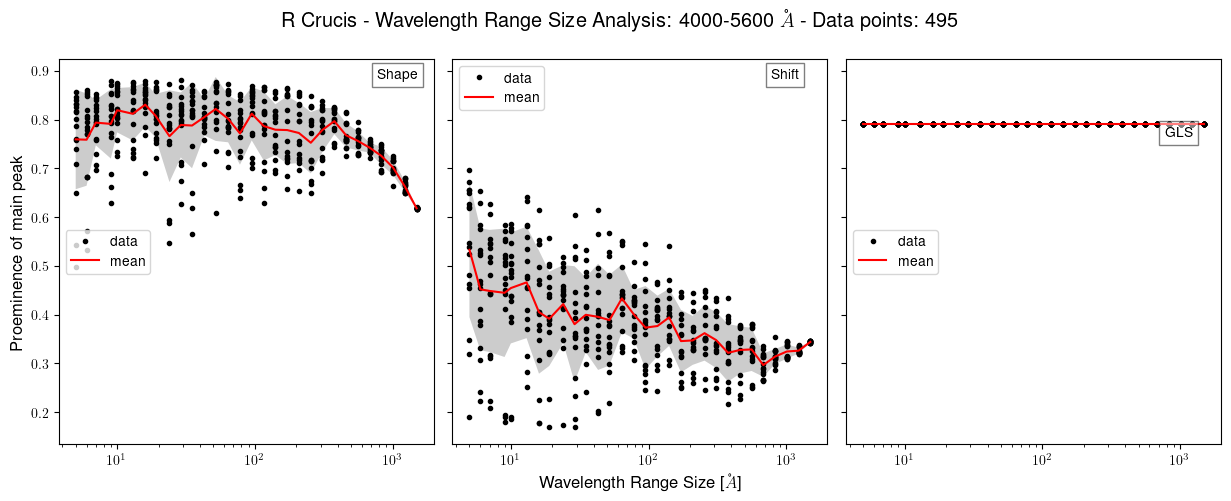

In [414]:
# plot the proeminences, put small box with shape, shift or gls
fig, ax = plt.subplots(1,3, figsize=(15,5),sharex=True,sharey=True)
plt.suptitle(r'R Crucis - Wavelength Range Size Analysis: 4000-5600 $\AA$ - Data points: '+str(len(RCru_results)), fontsize='x-large')
ax[0].plot(wv_ranges_size, shape_proeminences, '.',label='data')
#use fill_between to plot the std
ax[0].fill_between(wv_ranges_size_unique, np.array(shape_mean)-np.array(shape_std), np.array(shape_mean)+np.array(shape_std), alpha=0.2)
ax[0].plot(wv_ranges_size_unique, shape_mean, 'r-',label='mean')
ax[0].text(0.85, 0.95, 'Shape', transform=ax[0].transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax[0].set_ylabel('Proeminence of main peak', fontsize='large')
ax[1].plot(wv_ranges_size, shift_proeminences, '.',label='data')
ax[1].plot(wv_ranges_size_unique, shift_mean, 'r-',label='mean')
ax[1].fill_between(wv_ranges_size_unique, np.array(shift_mean)-np.array(shift_std), np.array(shift_mean)+np.array(shift_std), alpha=0.2)
ax[1].text(0.85, 0.95, 'Shift', transform=ax[1].transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax[1].set_xlabel('Wavelength Range Size [$\AA$]', fontsize='large')
ax[2].plot(wv_ranges_size, gls_proeminences, '.',label='data')
ax[2].plot(wv_ranges_size_unique, gls_mean, 'r-',label='mean')
ax[2].fill_between(wv_ranges_size_unique, np.array(gls_mean)-np.array(gls_std), np.array(gls_mean)+np.array(gls_std), alpha=0.2)
ax[2].text(0.85, 0.8, 'GLS', transform=ax[2].transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.subplots_adjust(wspace=0.05)
ax[0].legend(loc = 'center left')
ax[1].legend(loc='upper left')
ax[2].legend(loc = 'center left')
#put in log scale on x axis
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
plt.savefig('RCru_wv_ranges_proeminences.png', dpi=450)
plt.show()